SIS 1 - Data Collection & Preparation



Students: Serikbayeva Aruzhan and Saparbay Nursaya

In [16]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

# API — Studio Ghibli

api_url = "https://ghibliapi.vercel.app/films"
response = requests.get(api_url)
films_json = response.json()

# Collect key details about each Ghibli film
films = []
for f in films_json:
    films.append({
        "title": f["title"].strip(),
        "director": f["director"].strip(),
        "producer": f["producer"].strip(),
        "release_year": int(f["release_date"]),   # Year of release
        "running_time (min)": int(f["running_time"]),  # Duration in minutes
        "rt_score (/100)": int(f["rt_score"])          # Rotten Tomatoes rating
    })

ghibli_df = pd.DataFrame(films)
print(" Data from Ghibli API:")
display(ghibli_df.head())

# Web Scraping — BoxOfficeMojo

url = "https://www.boxofficemojo.com/brand/bn4084398594/"
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                  "AppleWebKit/605.1.15 (KHTML, like Gecko) "
                  "Version/17.1 Safari/605.1.15"
}
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.text, "html.parser")

# Find and parse the table with film earnings
table = soup.find("table")
rows = table.find_all("tr")

titles, lifetime, opening, theaters = [], [], [], []

for row in rows[1:]:
    cols = row.find_all("td")
    if len(cols) > 5:
        title = cols[1].text.strip()
        gross = cols[2].text.strip().replace("$", "").replace(",", "")
        theater = cols[3].text.strip().replace(",", "")
        open_gross = cols[4].text.strip().replace("$", "").replace(",", "")

        titles.append(title)
        lifetime.append(int(gross) if gross.isdigit() else None)       # Total lifetime box office (USD)
        opening.append(int(open_gross) if open_gross.isdigit() else None)  # Opening weekend gross (USD)
        theaters.append(int(theater) if theater.isdigit() else None)   # Max number of theaters shown

box_df = pd.DataFrame({
    "title": titles,
    "lifetime_gross ($)": lifetime,
    "opening_gross ($)": opening,
    "max_theaters (count)": theaters
})

print("\n Web Scraping works correctly:")
display(box_df.head())

# Cleaning & Preparation:


# Standardize titles for merging
ghibli_df["title_clean"] = ghibli_df["title"].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip()
box_df["title_clean"] = box_df["title"].str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip()

# If there are duplicates, sum all numeric columns
box_df = (
    box_df.groupby("title_clean", as_index=False)
    .agg({
        "title": "first",
        "lifetime_gross ($)": "sum",
        "opening_gross ($)": "sum",
        "max_theaters (count)": "sum"
    })
)

# Merge & Clean NaN


merged_df = pd.merge(ghibli_df, box_df, on="title_clean", how="inner")
merged_df.dropna(inplace=True)

# Final clean table
merged_df = merged_df[
    ["title_x", "director", "producer", "release_year", "running_time (min)",
     "rt_score (/100)", "lifetime_gross ($)", "opening_gross ($)", "max_theaters (count)"]
].rename(columns={"title_x": "title"})

print("\n Final merged dataset:")
display(merged_df.head(10))

print("\nMissing values check:")
print(merged_df.isna().sum())

# Descriptive Statistics & Correlation


print("\n Descriptive Statistics:")
desc = merged_df[[
    "running_time (min)", "rt_score (/100)",
    "lifetime_gross ($)", "opening_gross ($)", "max_theaters (count)"
]].describe().round(2)
display(desc)

# Simple Summary:


# Highest & Lowest Box Office
top_gross = merged_df.loc[merged_df["lifetime_gross ($)"].idxmax()]
low_gross = merged_df.loc[merged_df["lifetime_gross ($)"].idxmin()]

print(" HIGHEST BOX OFFICE")
print(f"   Movie: {top_gross['title']}")
print(f"   Total Gross: ${top_gross['lifetime_gross ($)']:,}")
print("\n LOWEST BOX OFFICE")
print(f"   Movie: {low_gross['title']}")
print(f"   Total Gross: ${low_gross['lifetime_gross ($)']:,}")

print("\n" + "="*60 + "\n")

#  Highest & Lowest Rating
top_rating = merged_df.loc[merged_df["rt_score (/100)"].idxmax()]
low_rating = merged_df.loc[merged_df["rt_score (/100)"].idxmin()]

print(" HIGHEST RATED MOVIE")
print(f"   Movie: {top_rating['title']}")
print(f"   Rating: {top_rating['rt_score (/100)']} /100")
print("\n LOWEST RATED MOVIE")
print(f"   Movie: {low_rating['title']}")
print(f"   Rating: {low_rating['rt_score (/100)']} /100")

print("\n" + "="*60 + "\n")

#  Longest & Shortest Movie
longest = merged_df.loc[merged_df["running_time (min)"].idxmax()]
shortest = merged_df.loc[merged_df["running_time (min)"].idxmin()]

print(" LONGEST MOVIE")
print(f"   Movie: {longest['title']}")
print(f"   Duration: {longest['running_time (min)']} min")
print("\n SHORTEST MOVIE")
print(f"   Movie: {shortest['title']}")
print(f"   Duration: {shortest['running_time (min)']} min")

print("\n" + "="*60 + "\n")

# Most & Least Theaters
most_theaters = merged_df.loc[merged_df["max_theaters (count)"].idxmax()]
least_theaters = merged_df.loc[merged_df["max_theaters (count)"].idxmin()]

print(" MOVIE SHOWN IN MOST THEATERS")
print(f"   Movie: {most_theaters['title']}")
print(f"   Theaters: {most_theaters['max_theaters (count)']:,}")
print("\n MOVIE SHOWN IN FEWEST THEATERS")
print(f"   Movie: {least_theaters['title']}")
print(f"   Theaters: {least_theaters['max_theaters (count)']:,}")

print("\n" + "="*60 + "\n")




 Data from Ghibli API:


,title,director,producer,release_year,running_time (min),rt_score (/100)
0,Castle in the Sky,Hayao Miyazaki,Isao Takahata,1986,124,95
1,Grave of the Fireflies,Isao Takahata,Toru Hara,1988,89,97
2,My Neighbor Totoro,Hayao Miyazaki,Hayao Miyazaki,1988,86,93
3,Kiki's Delivery Service,Hayao Miyazaki,Hayao Miyazaki,1989,102,96
4,Only Yesterday,Isao Takahata,Toshio Suzuki,1991,118,100



 Web Scraping works correctly:


,title,lifetime_gross ($),opening_gross ($),max_theaters (count)
0,The Secret World of Arrietty,19202743,6446395.0,1522.0
1,Ponyo,15090399,3585852.0,927.0
2,Spirited Away,10055859,449839.0,714.0
3,Princess Mononoke4K Restoration,6851056,3881024.0,630.0
4,The Wind Rises,5209580,313751.0,496.0



 Final merged dataset:


,title,director,producer,release_year,running_time (min),rt_score (/100),lifetime_gross ($),opening_gross ($),max_theaters (count)
0,Princess Mononoke,Hayao Miyazaki,Toshio Suzuki,1997,134,92,2375308,144446.0,129.0
1,Spirited Away,Hayao Miyazaki,Toshio Suzuki,2001,124,97,10055859,449839.0,714.0
2,Howl's Moving Castle,Hayao Miyazaki,Toshio Suzuki,2004,119,87,4711096,427987.0,202.0
3,Ponyo,Hayao Miyazaki,Toshio Suzuki,2008,100,92,15090399,3585852.0,927.0
4,From Up on Poppy Hill,Gorō Miyazaki,Toshio Suzuki,2011,91,83,1002895,57585.0,49.0
5,The Wind Rises,Hayao Miyazaki,Toshio Suzuki,2013,126,89,5209580,313751.0,496.0
6,The Tale of the Princess Kaguya,Isao Takahata,Yoshiaki Nishimura,2013,137,100,703232,54915.0,29.0
7,When Marnie Was There,Hiromasa Yonebayashi,Yoshiaki Nishimura,2014,103,92,561085,27388.0,57.0
8,The Red Turtle,Michaël Dudok de Wit,"Toshio Suzuki, Isao Takahata, Vincent Maraval,...",2016,80,93,921974,21010.0,127.0



Missing values check:
title                   0
director                0
producer                0
release_year            0
running_time (min)      0
rt_score (/100)         0
lifetime_gross ($)      0
opening_gross ($)       0
max_theaters (count)    0
dtype: int64

 Descriptive Statistics:


,running_time (min),rt_score (/100),lifetime_gross ($),opening_gross ($),max_theaters (count)
count,9.00,9.00,9.00,9.00,9.00
mean,112.67,91.67,4514603.11,564752.56,303.33
std,19.95,5.05,5037944.70,1145653.80,329.22
min,80.00,83.00,561085.00,21010.00,29.00
25%,100.00,89.00,921974.00,54915.00,57.00
50%,119.00,92.00,2375308.00,144446.00,129.00
75%,126.00,93.00,5209580.00,427987.00,496.00
max,137.00,100.00,15090399.00,3585852.00,927.00


 HIGHEST BOX OFFICE
   Movie: Ponyo
   Total Gross: $15,090,399

 LOWEST BOX OFFICE
   Movie: When Marnie Was There
   Total Gross: $561,085


 HIGHEST RATED MOVIE
   Movie: The Tale of the Princess Kaguya
   Rating: 100 /100

 LOWEST RATED MOVIE
   Movie: From Up on Poppy Hill
   Rating: 83 /100


 LONGEST MOVIE
   Movie: The Tale of the Princess Kaguya
   Duration: 137 min

 SHORTEST MOVIE
   Movie: The Red Turtle
   Duration: 80 min


 MOVIE SHOWN IN MOST THEATERS
   Movie: Ponyo
   Theaters: 927.0

 MOVIE SHOWN IN FEWEST THEATERS
   Movie: The Tale of the Princess Kaguya
   Theaters: 29.0




Visualization

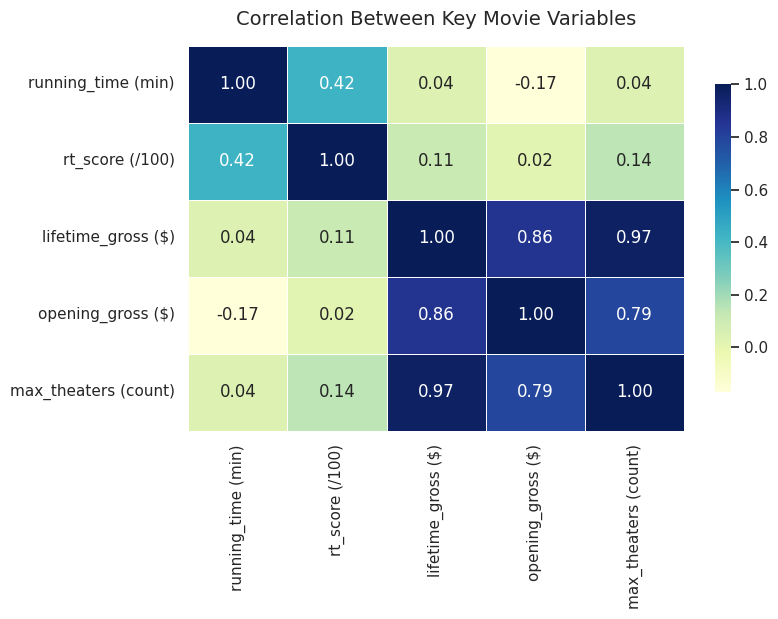

/tmp/ipython-input-2192485518.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


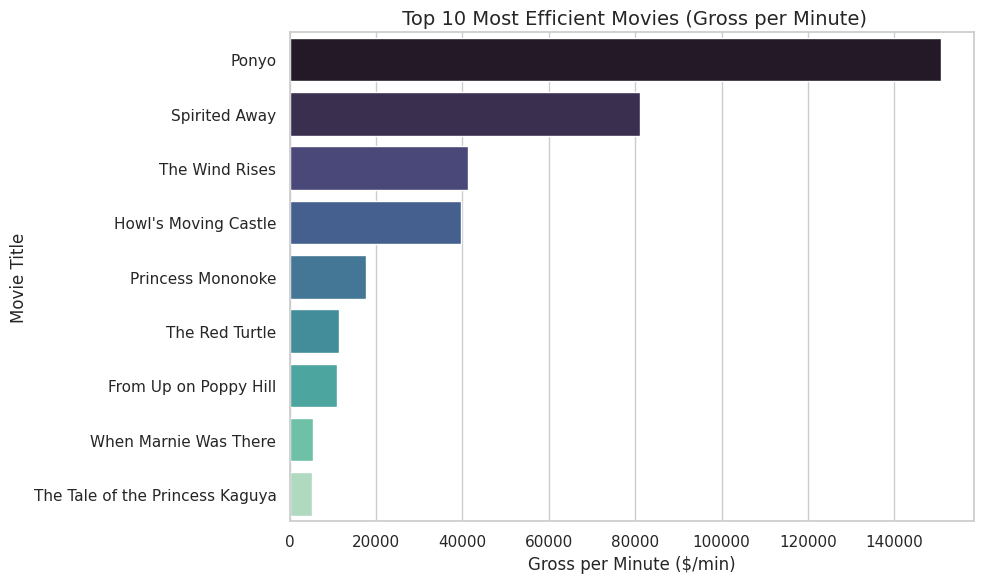

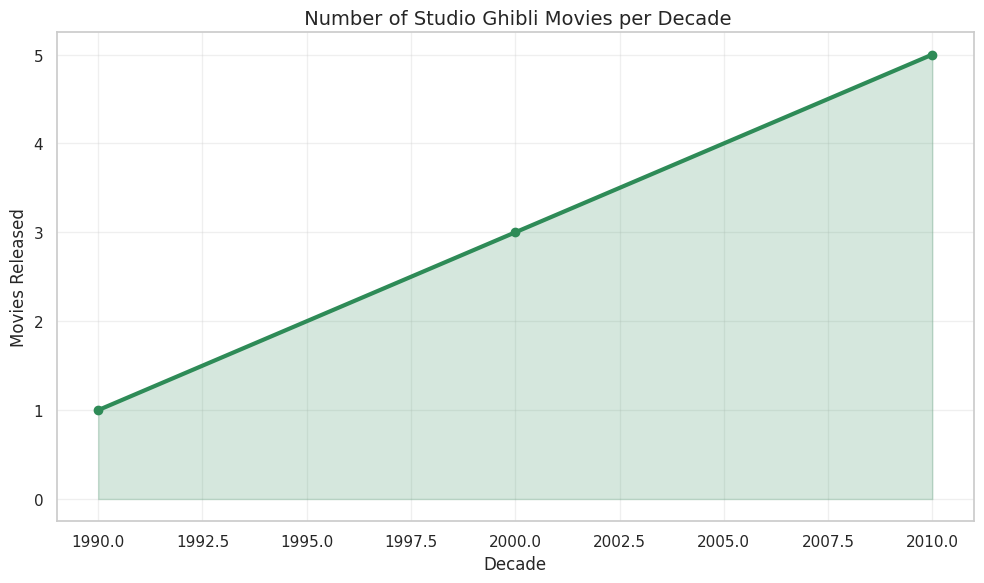



               director  rt_score (/100)
3         Isao Takahata            100.0
4  Michaël Dudok de Wit             93.0
2  Hiromasa Yonebayashi             92.0
1        Hayao Miyazaki             91.4
0         Gorō Miyazaki             83.0


/tmp/ipython-input-2192485518.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


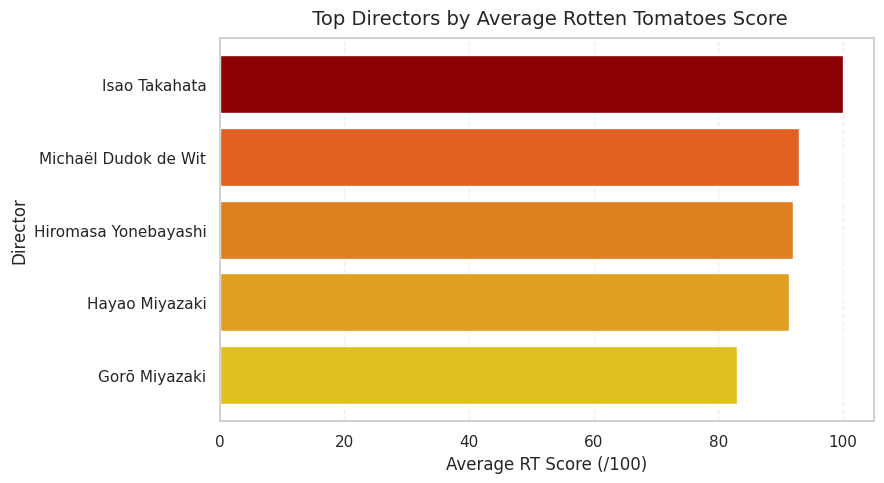



                                            producer  rt_score (/100)
2                                 Yoshiaki Nishimura             96.0
1  Toshio Suzuki, Isao Takahata, Vincent Maraval,...             93.0
0                                      Toshio Suzuki             90.0


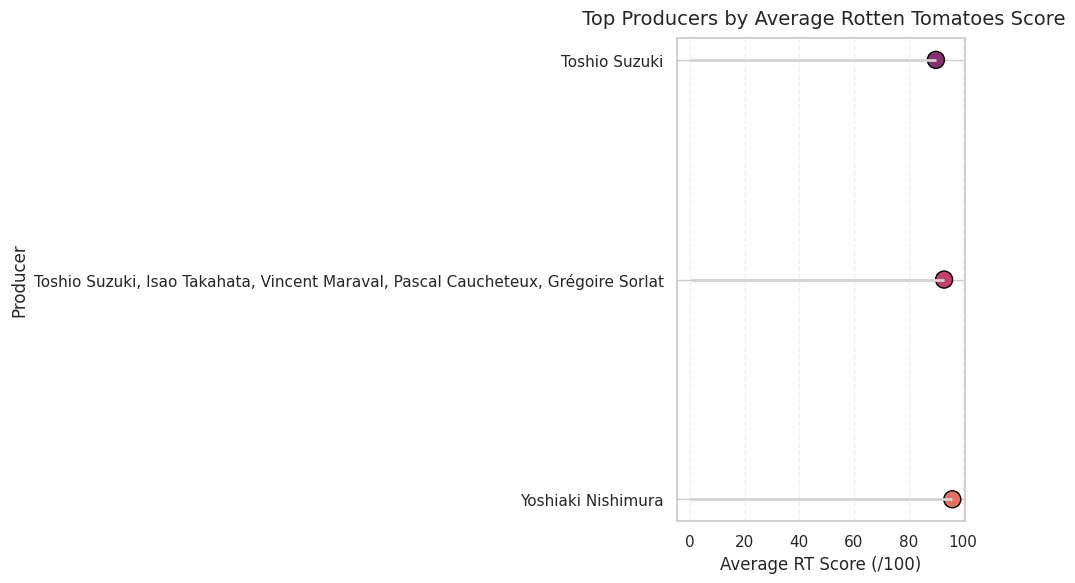

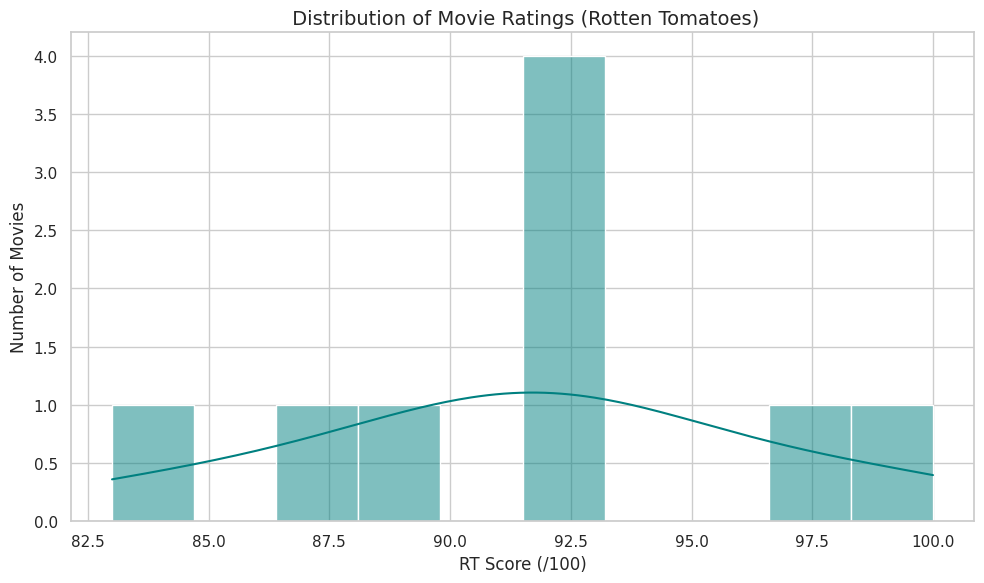

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Correlation Matrix

corr_matrix = merged_df[[
    "running_time (min)", "rt_score (/100)",
    "lifetime_gross ($)", "opening_gross ($)", "max_theaters (count)"
]].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Between Key Movie Variables", fontsize=14, pad=15)
plt.show()

print("\n" + "="*80 + "\n")

# Box Office Efficiency — Gross per Minute


merged_df["gross_per_minute ($/min)"] = merged_df["lifetime_gross ($)"] / merged_df["running_time (min)"]

efficiency_df = merged_df.sort_values("gross_per_minute ($/min)", ascending=False).head(10)

sns.barplot(
    data=efficiency_df,
    x="gross_per_minute ($/min)",
    y="title",
    palette="mako"
)
plt.title(" Top 10 Most Efficient Movies (Gross per Minute)", fontsize=14)
plt.xlabel("Gross per Minute ($/min)")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()

print("\n" + "="*80 + "\n")

# Movies per Decade

merged_df["decade"] = (merged_df["release_year"] // 10) * 10
decade_count = merged_df["decade"].value_counts().sort_index()

plt.plot(decade_count.index, decade_count.values, marker="o", color="seagreen", linewidth=3)
plt.fill_between(decade_count.index, decade_count.values, color="seagreen", alpha=0.2)
plt.title(" Number of Studio Ghibli Movies per Decade", fontsize=14)
plt.xlabel("Decade")
plt.ylabel("Movies Released")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80 + "\n")

# Top Directors by Average Rating

director_rating = (
    merged_df.groupby("director", as_index=False)
    .agg({"rt_score (/100)": "mean"})
    .sort_values("rt_score (/100)", ascending=False)
)
print(director_rating)

plt.figure(figsize=(9,5))
colors = sns.color_palette("autumn", len(director_rating))

sns.barplot(
    data=director_rating,
    y="director",
    x="rt_score (/100)",
    palette=colors
)

top_director = director_rating.iloc[0]
plt.barh(top_director["director"], top_director["rt_score (/100)"], color="darkred")

plt.title(" Top Directors by Average Rotten Tomatoes Score", fontsize=14, pad=10)
plt.xlabel("Average RT Score (/100)")
plt.ylabel("Director")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80 + "\n")

# Top Producers by Average Rating

producer_rating = (
    merged_df.groupby("producer", as_index=False)
    .agg({"rt_score (/100)": "mean"})
    .sort_values("rt_score (/100)", ascending=False)
)
print(producer_rating)

plt.figure(figsize=(10,6))
colors = sns.color_palette("flare", len(producer_rating))


plt.hlines(
    y=producer_rating["producer"],
    xmin=0,
    xmax=producer_rating["rt_score (/100)"],
    color="lightgray",
    linewidth=2
)


plt.scatter(
    producer_rating["rt_score (/100)"],
    producer_rating["producer"],
    s=150,
    color=colors,
    edgecolor="black",
    linewidth=1
)

plt.title(" Top Producers by Average Rotten Tomatoes Score", fontsize=14, pad=10)
plt.xlabel("Average RT Score (/100)")
plt.ylabel("Producer")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80 + "\n")



# Rating Distribution

sns.histplot(
    data=merged_df,
    x="rt_score (/100)",
    bins=10,
    kde=True,
    color="teal",
    edgecolor="white"
)
plt.title(" Distribution of Movie Ratings (Rotten Tomatoes)", fontsize=14)
plt.xlabel("RT Score (/100)")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

print("\n" + "="*80 + "\n")

